# OpenCV Object Tracking API

# OpenCV 4 Tracking API

OpenCV 4 comes with a new tracking API that contains implementations of many single object tracking algorithms. There are 8 different trackers available in OpenCV 4.1.0

1. BOOSTING, 

2. Multiple Instance Learning ( MIL ) 

3. Kernelized Correlation Filters (KCF) 

4. Tracking, learning and detection (TLD) 

5. MEDIANFLOW

6. GOTURN (Deep Learning based)

7. MOSSE

8. CSRT 



We will now explain various tracking algorithms implemented in OpenCV followed by their usage. 

# Object Tracking Algorithms

In this section, we will dig a bit into different tracking algorithms. The goal is not to have a deep theoretical understanding of every tracker, but to understand them from a practical standpoint.

Let us begin by first explaining some general principles behind tracking. In tracking, our goal is to find an object in the current frame given we have tracked the object successfully in all ( or nearly all ) previous frames.

Since we have tracked the object up until the current frame, we know how it has been moving. In other words, we know the parameters of the **motion model**. The motion model is just a fancy way of saying that you know the location and the velocity ( speed + direction of motion ) of the object in previous frames. If you knew nothing else about the object, you could predict the new location based on the current motion model, and you would be pretty close to where the new location of the object is. We used this approach while describing the Kalman filter. 

But we have more information than just the motion of the object. We know how the object looks in each of the previous frames. In other words, we can build an **appearance model** that encodes what the object looks like. This appearance model can be used to search in a small neighborhood of the location predicted by the motion model to more accurately predict the location of the object.

The motion model predicts the approximate location of the object. The appearance model fine tunes this estimate to provide a more accurate estimate based on appearance.

If the object was very simple and did not change it’s appearance much, we could use a simple template as an appearance model and look for that template. However, real life is not that simple. The appearance of an object can change dramatically. To tackle this problem, in many modern trackers, this appearance model is a **classifier** that is trained in an **online** manner. Don’t panic! Let me explain in simpler terms.

As we know from previous lectures, the job of a classifier is to classify a rectangular region of an image as either an object or background. The classifier takes in an image patch as input and returns a score between 0 and 1 to indicate the probability that the image patch contains the object. The score is 0 when it is absolutely sure the image patch is the background and 1 when it is absolutely sure the patch is the object.

When we trained our own classifier as part of a previous lecture, we spent hours in computation time for training a classifier. During tracking we do not have that luxury. In machine learning, we use the word "online" to refer to algorithms that are trained on the fly at run time. An *offline* classifier may need thousands of examples to train a classifier, but an *online* classifier is typically trained using a very few examples at run time.

A classifier is trained by feeding it positive ( object ) and negative ( background ) examples. If you want to build a classifier for detecting cats, you train it with thousands of images containing cats and thousands of images that do not contain cats. This way the classifier learns to differentiate what is a cat and what is not. 

Let’s look how different tracking algorithms approach this problem of online training.

## BOOSTING Tracker

This tracker is based on an online version of AdaBoost — the algorithm that the HAAR cascade based face detector uses internally. This classifier needs to be trained at runtime with positive and negative examples of the object. The initial bounding box supplied by the user ( or by another object detection algorithm ) is taken as the positive example for the object, and many image patches outside the bounding box are treated as the background. Given a new frame, the classifier is run on every pixel in the neighborhood of the previous location and the score of the classifier is recorded. The new location of the object is the one where the score is maximum. So now we have one more positive example for the classifier. As more frames come in, the classifier is updated with this additional data.

**Pros** : None. This algorithm is a decade old and works ok, but I could not find a good reason to use it especially when other advanced trackers (MIL, KCF) based on similar principles are available.

**Cons** : Tracking performance is mediocre. It does not reliably know when tracking has failed.

## MIL Tracker

This tracker is similar in idea to the BOOSTING tracker described above. The big difference is that instead of considering only the current location of the object as a positive example, it looks in a small neighborhood around the current location to generate several potential positive examples. You may be thinking that it is a bad idea because in most of these "positive" examples the object is not centered.

This is where Multiple Instance Learning ( MIL ) comes to rescue. In MIL, you do not specify positive and negative examples, but positive and negative "bags". The bag is labeled as positive if any of the instance in the bag is labeled as positive by the classifier. Otherwise the bag is labeled as negative. We will discuss this method in detail in the next chapter.

**Pros** : The performance is pretty good. It does not drift as much as the BOOSTING tracker and it does a reasonable job under partial occlusion. 

**Cons** : Tracking failure is not reported reliably. Does not recover from full occlusion.

## KCF Tracker

KCF stands for **Kernelized Correlation Filters**. This tracker builds on the ideas presented in the previous two trackers. This tracker utilizes the fact that the multiple positive samples used in the MIL tracker have large overlapping regions. This overlapping data leads to some nice mathematical properties that is exploited by this tracker to make tracking faster and more accurate at the same time.

**Pros**: Accuracy and speed are both better than MIL and it reports tracking failure better than BOOSTING and MIL. 

**Cons** : Does not recover from full occlusion. 

## TLD Tracker

TLD stands for **Tracking, learning and detection**. As the name suggests, this tracker decomposes the long term tracking task into three components — (short term) tracking, learning, and detection. From the author’s paper, "The tracker follows the object from frame to frame. The detector localizes all appearances that have been observed so far and corrects the tracker if necessary. The learning estimates detector’s errors and updates it to avoid these errors in the future." This output of this tracker tends to jump around a bit. For example, if you are tracking a pedestrian and there are other pedestrians in the scene, this tracker can sometimes temporarily track a different pedestrian than the one you intended to track. On the positive side, this track appears to track an object over a larger scale, motion, and occlusion. If you have a video sequence where the object is hidden behind another object, this tracker may be a good choice.

**Pros** : Works the best under occlusion over multiple frames. Also, tracks best over scale changes.

**Cons** : Lots of false positives making it almost unusable.

## MEDIANFLOW Tracker

Internally, this tracker tracks the object in both forward and backward directions in time and measures the discrepancies between these two trajectories. Minimizing this "ForwardBackward" error enables them to reliably detect tracking failures and select reliable trajectories in video sequences.

In ours tests, we found this tracker works best when the motion is predictable and small. Unlike, other trackers that keep going even when the tracking has clearly failed, this tracker knows when the tracking has failed.

**Pros** : Excellent tracking failure reporting. Works very well when the motion is predictable and there is no occlusion.

**Cons** : Fails under large motion.

## GOTURN tracker

Out of all the tracking algorithms in the tracker class, this is the only one based on Convolutional Neural Network (CNN). It is also the only one that uses an offline trained model, because of which it is faster that other trackers. From OpenCV documentation, we know it is "robust to viewpoint changes, lighting changes, and deformations". But it does not handle occlusion very well.

**NOTE :** GOTURN being a CNN based tracker, uses a caffe model for tracking. The Caffe model and the prototxt file must be present in the directory in which the code is present. You can download the files from [this link](https://www.dropbox.com/sh/77frbrkmf9ojfm6/AACgY7-wSfj-LIyYcOgUSZ0Ua?dl=0).

## MOSSE tracker
The idea of using correlation filters for tracking is very old. However, if we simply use an image patch around the detected object and try to find its location in the next frame using correlation the results are not very good. This is because the image patch appearance may change quite a bit. 

Minimum Output Sum of Squared Error (MOSSE) uses discriminative correlation filter (DCF) for object tracking which produces stable correlation filters when initialized using a single frame. When the paper was published in 2010, it surprised the community because of it simplicity. It was an old idea that was modified slightly, and was able to outperform other algorithms that used heavy duty classifiers, complex appearance models, and stochastic search techniques. It was also substantially faster. 

MOSSE tracker is robust to variations in lighting, scale, pose, and non-rigid deformations. It also detects occlusion based upon the peak-to-sidelobe ratio, which enables the tracker to pause and resume where it left off when the object reappears. MOSSE tracker also operates at a higher fps (450 fps and even more). 

## CSRT tracker
The CRST tracker extends the Discriminative Correlation Filter (DCF) idea in MOSSE with what the authors call Channel and Spatial Reliability (DCF-CSR). In particular, they are able to extend the search region over while the search is performed. This ensures enlarging and localization of the selected region and improved tracking of the non-rectangular regions or objects. It uses only 2 standard features (HoGs and Colornames). It also operates at a comparatively lower fps (25 fps) but gives higher accuracy for object tracking.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [3]:
# Set up tracker.
# Instead of MIL, you can also use

tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'CSRT', 'MOSSE']
tracker_type = tracker_types[2]

In [4]:
if tracker_type == 'BOOSTING':
    tracker = cv2.TrackerBoosting_create()
elif tracker_type == 'MIL':
    tracker = cv2.TrackerMIL_create()
elif tracker_type == 'KCF':
    tracker = cv2.TrackerKCF_create()
elif tracker_type == 'TLD':
    tracker = cv2.TrackerTLD_create()
elif tracker_type == 'MEDIANFLOW':
    tracker = cv2.TrackerMedianFlow_create()
elif tracker_type == 'GOTURN':
    tracker = cv2.TrackerGOTURN_create()
elif tracker_type == "CSRT":
    tracker = cv2.TrackerCSRT_create()
elif tracker_type == "MOSSE":
    tracker = cv2.TrackerMOSSE_create()
else:
    tracker = None
    print('Incorrect tracker name')
    print('Available trackers are:')
    for t in trackerTypes:
        print(t)

In [5]:
# Read video
video = cv2.VideoCapture(DATA_PATH + "videos/hockey.mp4")

# Exit if video not opened.
if not video.isOpened():
    print("Could not open video")

# Read first frame.
ok, frame = video.read()
if not ok:
    print('Cannot read video file')

# Define a few colors for drawing
red = (0,0,255)
blue = (255,128,0)

Next a bounding box to be tracked is defined. Alternatively, selectROI can be used to select a bounding box. The tracker is initialized using the current frame and the bounding box using the init method. 

We have given below the bounding box we used for different videos. Uncomment the line to use the bbox.

In [ ]:
# Define an initial bounding box
# Cycle
bbox = (477, 254, 55, 152)

# ship
# bbox = (751, 146, 51, 78)

# Hockey
# bbox = (129, 47, 74, 85)

# Face2
# bbox = (237, 145, 74, 88)

# meeting
# bbox = (627, 183, 208, 190)     #CSRT
# bbox = (652, 187, 118, 123)       #KCF

# surfing
# bbox = (97, 329, 118, 293)

# surf
# bbox = (548, 587, 52, 87)

# spinning
# bbox = (232, 218, 377, 377)       #RED
# bbox = (699, 208, 383, 391)         #BLUE

# Car
# bbox = (71, 457, 254, 188)

Text(0.5, 1.0, 'Tracking')

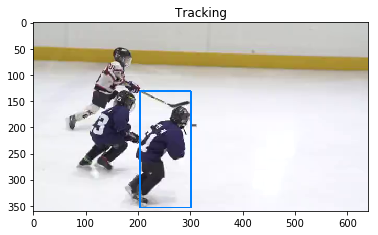

In [6]:
# Uncomment the line below to select a different bounding box
# bbox = cv2.selectROI(frame, False)

# Initialize tracker with first frame and bounding box
ok = tracker.init(frame, bbox)

# Display bounding box.
p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(frame, p1, p2, blue, 2, 1 )

plt.imshow(frame[:,:,::-1])
plt.title("Tracking")

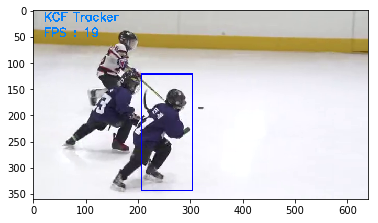

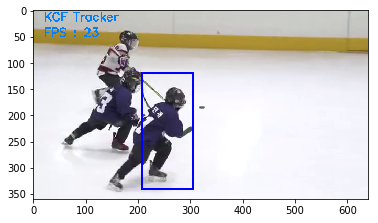

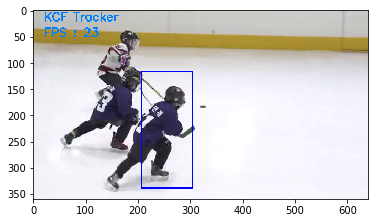

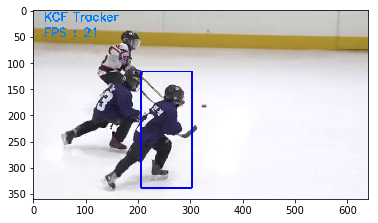

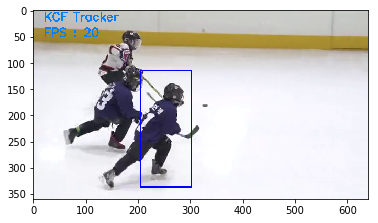

In [9]:
# We will display only first 5 frames
count = 0

while True:
    # Read a new frame
    ok, frame = video.read()
    if not ok:
        break

    # Start timer
    timer = cv2.getTickCount()
    
    # The update method is used to obtain the location 
    # of the new tracked object. The method returns
    # false when the track is lost. Tracking can fail 
    # because the object went outside the video frame or 
    # if the tracker failed to track the object. 
    # In both cases, a false value is returned.
    
    # Update tracker
    ok, bbox = tracker.update(frame)
    
    # Calculate processing time and display results.
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer);

    # Draw bounding box
    if ok:
      # Tracking success
      p1 = (int(bbox[0]), int(bbox[1]))
      p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
      cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)
    else :
      # Tracking failure
      cv2.putText(frame, "Tracking failure detected", (20,80), 
                  cv2.FONT_HERSHEY_SIMPLEX, 0.75,red,2)

    # Display tracker type on frame
    cv2.putText(frame, tracker_type + " Tracker", (20,20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, blue,2);
    
    # Display FPS on frame
    cv2.putText(frame, "FPS : " + str(int(fps)), (20,50), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, blue, 2);

    # Display result
    plt.imshow(frame[:,:,::-1])
    plt.show()
    
    count += 1
    if count == 5:
        break

# Combining Detection and Tracking

Quite surprisingly, there is no way to update the results of tracking using a detection algorithm using OpenCV’s tracker class. One would expect the **update** or the **init** methods or a completely separate method would allow a user to provide hints to the tracker using a detector. However, this is not the case. The only way to combine the results of tracking with a detection algorithm is to start a new tracker using the create method. 

# Reference and Further Reading

1. [http://www.vision.ee.ethz.ch/boostingTrackers/Grabner2006RealTimeTracking.pdf](http://www.vision.ee.ethz.ch/boostingTrackers/Grabner2006RealTimeTracking.pdf)

2. [http://vision.ucsd.edu/~bbabenko/new/project_miltrack.shtml](http://vision.ucsd.edu/~bbabenko/new/project_miltrack.shtml)

3. [https://arxiv.org/abs/1404.7584](https://arxiv.org/abs/1404.7584)

4. [http://kahlan.eps.surrey.ac.uk/featurespace/tld/Publications/2011_tpami](http://kahlan.eps.surrey.ac.uk/featurespace/tld/Publications/2011_tpami)

5. [http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.231.4285&rep=rep1&type=pdf](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.231.4285&rep=rep1&type=pdf)

6. [http://davheld.github.io/GOTURN/GOTURN.pdf](http://davheld.github.io/GOTURN/GOTURN.pdf)

7. [http://docs.opencv.org/trunk/d0/d0a/classcv_1_1Tracker.html](http://docs.opencv.org/trunk/d0/d0a/classcv_1_1Tracker.html)